<a href="https://colab.research.google.com/github/lucila-03/ML/blob/main/MVP%20Qualidade%20do%20Ar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP para Análise de Informações do INSS
## Lucila da Conceição Castello Branco


    ###Separe o dataset entre treino e teste (e validação, se aplicável).
    Faz sentido utilizar um método de validação cruzada? Justifique se não utilizar.
    Verifique quais operações de transformação de dados (como normalização e padronização, transformação de imagens em tensores) são mais apropriadas para o seu problema e salve visões diferentes do seu dataset para posterior avaliação dos modelos.
    Refine a quantidade de atributos disponíveis, realizando o processo de feature selection de forma adequada.

## 1. Definição do Problema *

O dataset usado neste projeto será um arquivo do governo com informações da Comunicação de Acidentes de Trabalho (CAT), são somente as informações que governo disponibiliza, o arquivo estava guardado e foi modificado para ter somente informações relevantes para análise de acidentes de Janeiro e Fevereiro de 2019. O objetivo deste projeto é conhecer os tipos de acidentados em janeiro e fevereiro de 2019.

**Informações sobre os atributos:**
1. **Data Acidente** - Mês e ano da ocorrência
2. **Parte Corpo** - parte do corpo lesionado
3. **Sexo** - Masculino / Feminino
4. **Tipo de acidente** - Os acidentes são classificados conforme o tipo de ocorrência, pode ser típicos ( quando ocorreu na execução do trabalho) ou trajeto ( em deslocamento entre trabalho e casa ou deslocamento no almoço)
5. **UF  Munic.  Acidente** - localização(Estado) que o funcionário estava quando se acidentou.
6. **UF Munic. Empregador** - localização(Estado) que a empresa trabalha
7. **Idade** - idade (anos) do acidentado no dia so acidente

In [38]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


## 2. Carga de Dados

In [39]:
# Carrega arquivo csv usando Pandas usando uma URL

# Importação do dataset

url = "https://raw.githubusercontent.com/lucila-03/Acidente/main/dataset%20cat.csv"
dataset = pd.read_csv(url, delimiter = ";", encoding='ISO-8859-1' )

## 3. Análise de Dados e tratamento

Será realizado um levantamento dos tipos de dados, análise e ajustes para que a base de dados fique pronta para o estudo.

In [40]:
# Mostra as dimensões do dataset
dataset.shape

(77985, 8)

In [41]:
# Mostra as informações do dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77985 entries, 0 to 77984
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Data Acidente         77985 non-null  object
 1   Natureza da Lesão     77953 non-null  object
 2   Parte Corpo Atingida  77985 non-null  object
 3   Sexo                  77985 non-null  object
 4   Tipo do Acidente      77985 non-null  object
 5   UF  Munic.  Acidente  54146 non-null  object
 6   UF Munic. Empregador  77985 non-null  object
 7   Idade                 77985 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 4.8+ MB


Foi identificado que os Estados dos acidentados apresentam inconsistências que precisam ser tratadas.
Saber o lugar (Estado) em que o colaborador se acidentou é um a informação relevante, com a ausência da informação, será utilizado o estado em que a empresa está localizada.
Como o foco são os acidentes, após o tratamento a UF do Empregador será retirada.

In [42]:
# Função personalizada para substituir os dados sem informação da coluna UF Munic. Acidente
dataset['UF  Munic.  Acidente'] = dataset['UF  Munic.  Acidente'].fillna(dataset['UF Munic. Empregador'])
dataset.head(5)

,Data Acidente,Natureza da Lesão,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Idade
0,2019/01,Lesao Imediata,Dedo,Feminino,Típico,Espírito Santo,Espírito Santo,23
1,2019/01,Lesao Imediata,Antebraco (Entre O P,Masculino,Típico,Rio Grande do Sul,Rio Grande do Sul,26
2,2019/01,Perda ou Diminuicao,Dorso (Inclusive Mus,Feminino,Trajeto,Pará,Pernambuco,35
3,2019/01,"Corte, Laceracao, Fe",Dedo,Feminino,Típico,Rondônia,Minas Gerais,30
4,2019/01,"Dermatose (Erupcao,","Face, Partes Multipl",Feminino,Típico,Rio Grande do Sul,Rio Grande do Sul,32


In [43]:
# Remover as linhas com valores nulos
dataset = pd.DataFrame(dataset).dropna()

In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77953 entries, 0 to 77984
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Data Acidente         77953 non-null  object
 1   Natureza da Lesão     77953 non-null  object
 2   Parte Corpo Atingida  77953 non-null  object
 3   Sexo                  77953 non-null  object
 4   Tipo do Acidente      77953 non-null  object
 5   UF  Munic.  Acidente  77953 non-null  object
 6   UF Munic. Empregador  77953 non-null  object
 7   Idade                 77953 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 5.4+ MB


Para dar andamento ao projeto seria interessante conhecer melhor os dados do dataset.

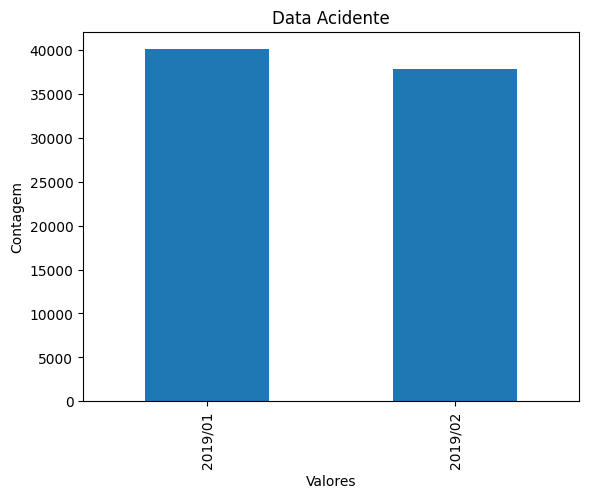

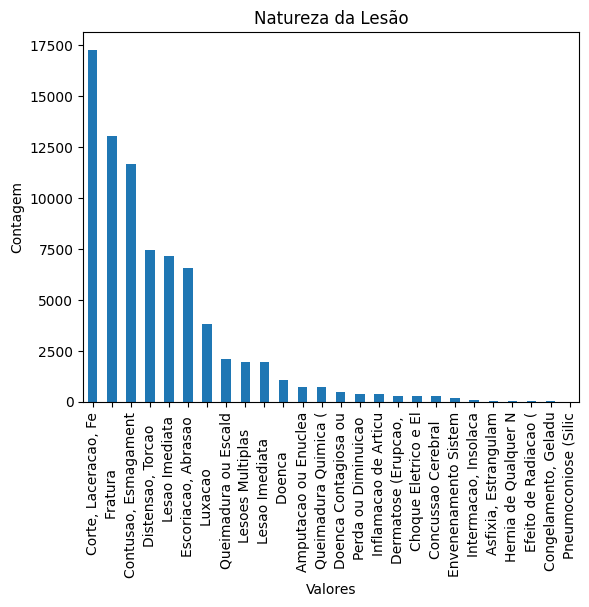

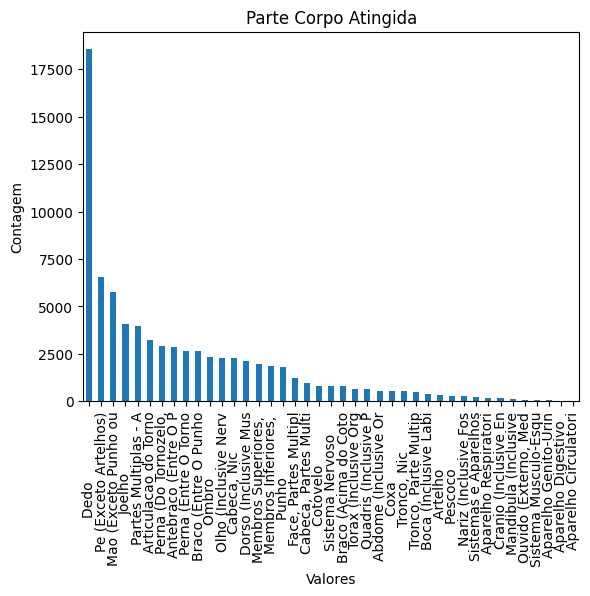

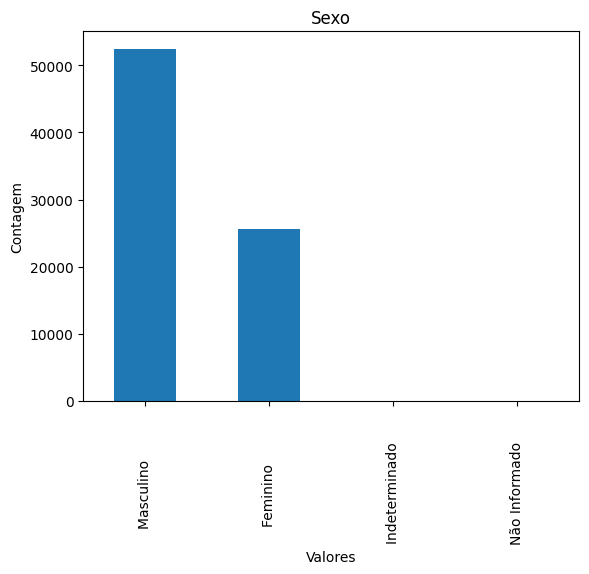

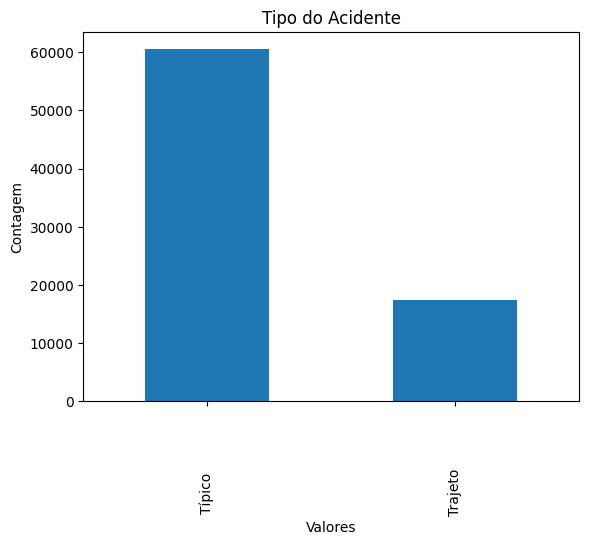

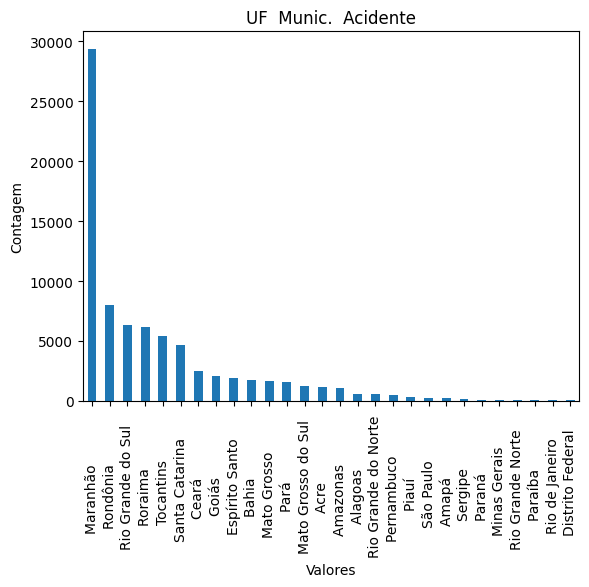

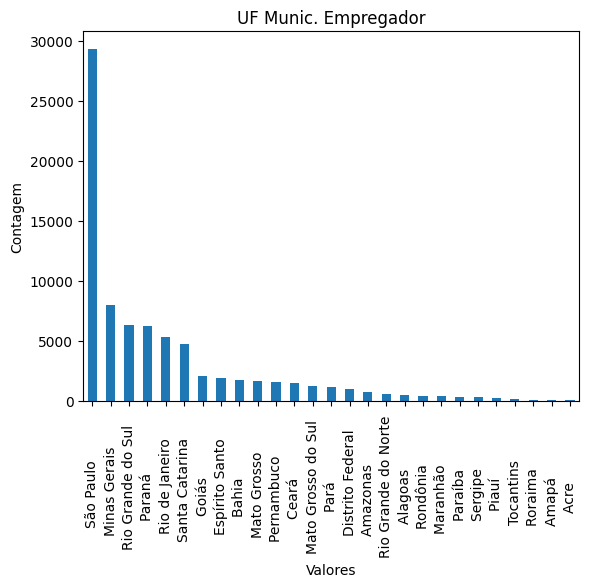

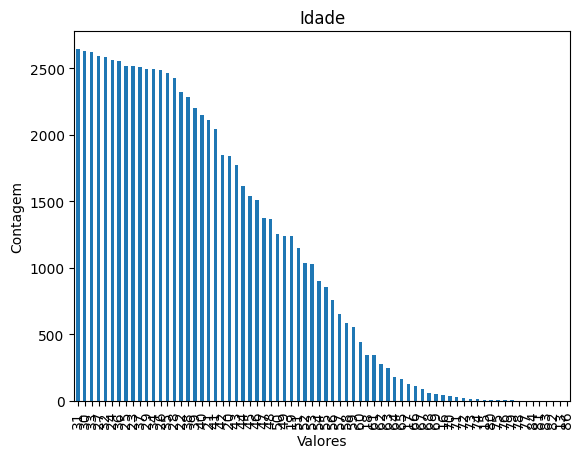

In [45]:
# Plotar um gráfico de colunas para cada coluna do dataframe
for coluna in dataset.columns:
    plt.figure()  # Cria uma nova figura para cada gráfico de colunas
    dataset[coluna].value_counts().plot(kind='bar')
    plt.title(coluna)  # Define o título do gráfico como o nome da coluna
    plt.xlabel('Valores')  # Define o rótulo do eixo x
    plt.ylabel('Contagem')  # Define o rótulo do eixo y

plt.show()

Análise das informações:

Data: são dois meses, não há necessidade de ajustes.
Sexo: diferenciação por sexo pode ser interesante, tem a questão do LGBTQIA+, mas como não foi abordado e as opções indeterminado e não informado é pequena em relação aos outros,serão agrupados como Indeterminado.
Os demais dados tem uma variação grande, conforme andamento do projeto, pode ser interessante agrupar.

In [46]:
# Função para ajustar coluna sexo
def agrupar_sexo(valor):
    if valor in ['Masculino           ']:
        return 'Masculino'
    elif valor in ['Feminino            ']:
        return 'Feminino'
    else:
        return 'Indeterminado'

# Aplicar a função à coluna 'Sexo' e criar uma nova coluna
pd.DataFrame(dataset)['Sexo1'] = pd.DataFrame(dataset)['Sexo'].apply(agrupar_sexo)

In [47]:
# Eliminando colunas desnecessárias

# Criando uma cópia do dataset
dados = dataset.copy()

# Removendo as colunas indesejadas na cópia do dataset
remover_colunas = ['Data Acidente', 'Sexo', 'UF Munic. Empregador']
dados = dados.drop(remover_colunas, axis=1)

In [48]:
dados.head(5)

,Natureza da Lesão,Parte Corpo Atingida,Tipo do Acidente,UF Munic. Acidente,Idade,Sexo1
0,Lesao Imediata,Dedo,Típico,Espírito Santo,23,Feminino
1,Lesao Imediata,Antebraco (Entre O P,Típico,Rio Grande do Sul,26,Masculino
2,Perda ou Diminuicao,Dorso (Inclusive Mus,Trajeto,Pará,35,Feminino
3,"Corte, Laceracao, Fe",Dedo,Típico,Rondônia,30,Feminino
4,"Dermatose (Erupcao,","Face, Partes Multipl",Típico,Rio Grande do Sul,32,Feminino


In [49]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77953 entries, 0 to 77984
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Natureza da Lesão     77953 non-null  object
 1   Parte Corpo Atingida  77953 non-null  object
 2   Tipo do Acidente      77953 non-null  object
 3   UF  Munic.  Acidente  77953 non-null  object
 4   Idade                 77953 non-null  int64 
 5   Sexo1                 77953 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.2+ MB


Faz-se necessário o uso de uma codificação ordinal nos dados categoricos

In [50]:
# Criar uma instância do OrdinalEncoder
encoder = OrdinalEncoder()

# Aplicar a codificação ordinal em todo o dataframe
dados_co = encoder.fit_transform(dados)

# Converter o resultado de volta para um dataframe
dados_co = pd.DataFrame(dados_co, columns=dados.columns)

# Verificar o dataframe resultante
print(dados_co.head())

   Natureza da Lesão  Parte Corpo Atingida  Tipo do Acidente  \
0               18.0                  16.0               1.0   
1               18.0                   1.0               1.0   
2               22.0                  17.0               0.0   
3                6.0                  16.0               1.0   
4                7.0                  18.0               1.0   

   UF  Munic.  Acidente  Idade  Sexo1  
0                   7.0    9.0    0.0  
1                  20.0   12.0    2.0  
2                  15.0   21.0    0.0  
3                  22.0   16.0    0.0  
4                  20.0   18.0    0.0  


In [51]:
pd.DataFrame(dados_co)['Target'] = pd.DataFrame(dados_co)['Parte Corpo Atingida']
dados_co = dados_co.drop(['Parte Corpo Atingida'], axis=1)
dados_co.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77953 entries, 0 to 77952
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Natureza da Lesão     77953 non-null  float64
 1   Tipo do Acidente      77953 non-null  float64
 2   UF  Munic.  Acidente  77953 non-null  float64
 3   Idade                 77953 non-null  float64
 4   Sexo1                 77953 non-null  float64
 5   Target                77953 non-null  float64
dtypes: float64(6)
memory usage: 3.6 MB


## 4. Modelagem e Inferência


###Criação e avaliação do modelo



In [52]:
# Separação em bases de treino e teste (holdout)
array = dados_co.values
X = array[:,0:5] # atributos
y = array[:,5] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7) # faz a divisão

# Validação cruzada
scoring = 'accuracy'
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

Modelagem dos dados

In [53]:
# Definindo uma seed global para esta célula de código
np.random.seed(7)

## Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', MultinomialNB()))
#models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
#models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring= scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR: 0.260340 (0.004922)
KNN: 0.212473 (0.006014)
CART: 0.235105 (0.005252)
NB: 0.222094 (0.003158)
Bagging: 0.241501 (0.005813)
RF: 0.241758 (0.005563)
ET: 0.240017 (0.004977)
Ada: 0.151079 (0.064393)


KeyboardInterrupt: ignored

Com base nos resultados apresentados, todos parecem bons, mas a acurácia de 100% foram CART e SVM.
O escolhido foi o CART porque o SVM demora muito para rodar.
Por serem dados categóricos, não devem ser padronizados nem normalizados.

Ver ML_Aula3b fala do feature selection

In [ ]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = LogisticRegression(max_iter=200)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

## 4. Pré-Processamento de dados

Nesta etapa, poderíamos realizar diversas operações de preparação de dados, como por exemplo, tratamento de valores missings (faltantes), limpeza de dados, transformações como one-hot-encoding, seleção de características (feature selection), entre outras não mostradas neste notebook. Lembre-se de não criar uma versão padronizada/normalizada dos dados neste momento (apesar de serem operações de pré-processamento) para evitar o Data Leakage.

### 4.2. Separação em conjunto de treino e conjunto de teste

É uma boa prática usar um conjunto de teste (na literatura também chamado de conjunto de validação), uma amostra dos dados que não será usada para a construção do modelo, mas somente no fim do projeto para confirmar a precisão do modelo final. É um teste que podemos usar para verificar o quão boa foi a construção do modelo, e para nos dar uma ideia de como o modelo irá performar nas estimativas em dados não vistos. Usaremos 80% do conjunto de dados para modelagem e guardaremos 20% para teste, usando a estratégia train-test-split, já explicada anteriormente. Primeiramente, iremos sinalizar quais são as colunas de atributos (X - 0 a 7) e qual é a coluna das classes (Y - 8). Em seguida, especificaremos o tamanho do conjunto de teste desejado e uma semente (para garantir a reprodutibilidade dos resultados). Finalmente, faremos a separação dos conjuntos de treino e teste através do comando train_test_split, que retornará 4 estruturas de dados: os atributos e classes para o conjunto de teste e os atributos e classes para o conjunto de treino.


In [ ]:
# Preparação dos dados

# Separação em bases de treino e teste (holdout)
array = dataset.values
X = array[:,0:13] # atributos
y = array[:,13] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão

# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds